### CNN
#### Convolutional Layer

$(W-F+2P)/S+1$

例如：5x5 input, 3x3 filter, padding=0, stride=1

$(5-3+0)/1+1=3$

得到的图像为 3x3

#### Max Pooling
Reduce computational cost

Avoid over-fitting

In [1]:
# GPU support
# CIFAR-10
# DataLoader, Transformation
# Multilayer Neural Net, activation function
# Loss and Optimizer
# Training Loop (batch training)
# model evaluation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32]) torch.Size([4])


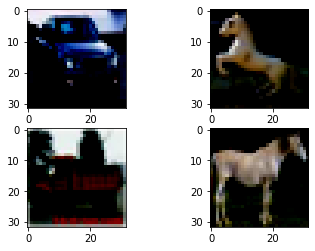

In [4]:
# dataset has PILImage images of range [0, 1]
# we transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## download=True make sure it would be downloaded if it's not available
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

# DataLoader, Transformation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)
# torch.Size([100, 1, 28, 28]) torch.Size([100])
# [batch_size, num_channels, image_h, image_w] [batch_size]

for i in range(4):
    plt.subplot(2, 2, i+1)
#     plt.imshow(samples[i][0], cmap='gray') # [0] 表示 channel， cmap=color map
    plt.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.show()

In [5]:
# Multilayer Neural Net, activation function
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input_channel_size, output_channel_size, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # conv2.input_channel_size = conv1.output_channel_size
        self.fc1 = nn.Linear(16*5*5, 120) # fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # 原来 torch.Size 是 [4, 3, 32, 32]
        
        # 经过卷基层后变成 [4, 6, 28, 28]
        # batch_size=4, input_channel_size=3, output_channel_size=6
        # W=32, F=5, P=0, S=1, (W-F+2P)/S+1=28
        # activation function 不改变 torch.Size
        
        # 经过池化层后变为 [4, 6, 14, 14]
        # 28/2=14
        
        # 再次卷积变为 [4e
        # W=14, F=5, P=0, S=1, (W-F+2P)/S+1=10
        
        # 再次池化，变成 [4, 16, 5, 5]
        # 因此第一个全连接层的 input_size 为 16*5*5

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # 这里因为要使用 Cross Entropy，所以不用添加 Softmax
        return x
        
model = ConvNet().to(device)

In [6]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # now we have to reshape images first
        # batch_size=100, num_channel=1, 28, 28
        # num_samples=100, num_features=784=28x28
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update parameters
        
        if (i+1) % 2000 == 0:
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}")
            
print("Finished Training")            

epoch 1/4, step 2000/12500, loss = 2.2905
epoch 1/4, step 4000/12500, loss = 2.3133
epoch 1/4, step 6000/12500, loss = 2.3030
epoch 1/4, step 8000/12500, loss = 2.3121
epoch 1/4, step 10000/12500, loss = 2.3041
epoch 1/4, step 12000/12500, loss = 2.2654
epoch 2/4, step 2000/12500, loss = 2.3701
epoch 2/4, step 4000/12500, loss = 2.3014
epoch 2/4, step 6000/12500, loss = 2.1848
epoch 2/4, step 8000/12500, loss = 2.2493
epoch 2/4, step 10000/12500, loss = 2.3219
epoch 2/4, step 12000/12500, loss = 2.3685
epoch 3/4, step 2000/12500, loss = 2.3030
epoch 3/4, step 4000/12500, loss = 1.9219
epoch 3/4, step 6000/12500, loss = 2.1521
epoch 3/4, step 8000/12500, loss = 2.2596
epoch 3/4, step 10000/12500, loss = 2.3907
epoch 3/4, step 12000/12500, loss = 2.2912
epoch 4/4, step 2000/12500, loss = 2.2367
epoch 4/4, step 4000/12500, loss = 1.4583
epoch 4/4, step 6000/12500, loss = 2.1116
epoch 4/4, step 8000/12500, loss = 1.8370
epoch 4/4, step 10000/12500, loss = 1.7394
epoch 4/4, step 12000/12500

In [8]:
# model evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predictions[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
acc = 100.0 * n_correct / n_samples
print(f"Accuracy of the network = {acc}")

Accuracy of the network = 32.37


In [9]:
for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f"Accuracy of {classes[i]}: {acc} %")

Accuracy of plane: 45.2 %
Accuracy of car: 37.4 %
Accuracy of bird: 0.0 %
Accuracy of cat: 20.3 %
Accuracy of deer: 0.0 %
Accuracy of dog: 49.1 %
Accuracy of frog: 65.9 %
Accuracy of horse: 0.0 %
Accuracy of ship: 45.4 %
Accuracy of truck: 60.4 %
